In [ ]:
#|default_exp core
## Standard libraries
import os
import math
import numpy as np
import time
# Configure environment
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false' # Tells Jax not to hog all of the memory to this process.

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgba
import seaborn as sns
sns.set()

## Progress bar
from tqdm.auto import tqdm

## project specifics
import diffusion_curvature
from diffusion_curvature.kernels import *
from diffusion_curvature.datasets import *
import jax
import jax.numpy as jnp
jax.devices()

%load_ext autoreload
%autoreload 2

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


# Implementation (PyGSP + JAX)
> Curvature computations on any graphtools graph

This notebook implements diffusion curvature atop the popular PyGSP library. To compute the curvature of any PyGSP graph, simply instantiate a `DiffusionCurvature` object with your choice of parameters, and pass the graphtools graph through as input.

What follows is a literate implementation, showing the steps of the algorithm applied to our old friend, the torus.

The implementation of Diffusion Curvature involves several big pieces, each of which can be performed with different strategies:

1. Simulating heat diffusion on the manifold, either via powering the diffusion matrix, or by Chebyshev approximation of the heat equation using the graph laplacian.
2. Computing the "spreads" of diffusion. This can be done either via the entropy or the Wasserstein distance.
3. Constructing a comparison space of approximately the same sampling as the input graph.
4. (Experimental) Verification that the above is working by differentiating the spreads of diffusion over time.

We implement everything generically in JAX (a high performance numpy replacement, which can compile to the GPU), treating each of the above as modules that can be parametrically tuned. Functional programming is our game: each function takes a graph object as input and returns an updated graph object with the required quantities computed. 

In [ ]:
from diffusion_curvature.datasets import torus

In [ ]:
# Our sample dataset for testing the rest of the notebook
X_torus, ks_torus = torus(5000,use_guide_points=True)

# Graph Construction
Our 'Graphs' notebook has code to create PyGSP graphs from pointcloud data, in several varieties. 
We also provide heuristics to sanity check the graphs, as well as choose the optimal parameters.
TODO: MAKE THESE HEURISTICS

In [ ]:
from diffusion_curvature.graphs import get_alpha_decay_graph, get_knn_graph, get_scanpy_graph

In [ ]:
G_torus = get_alpha_decay_graph(X_torus,knn=15,decay=20,anisotropy=1.0)

# The Diffusion Curvature Class

In [ ]:
#|export
import pygsp
import jax
import jax.numpy as jnp
import numpy as np
from fastcore.all import *
import skdim
import scipy
from sklearn.preprocessing import normalize

from inspect import getfullargspec
from typing import Callable, Literal, get_args, get_origin
import graphtools
from tqdm.auto import trange, tqdm

from jax.experimental import sparse

from diffusion_curvature.graphs import diff_aff, diff_op, diffusion_matrix_from_affinities
from diffusion_curvature.heat_diffusion import heat_diffusion_on_signal, kronecker_delta, jax_power_matrix, heat_diffusion_from_dirac
from diffusion_curvature.diffusion_laziness import wasserstein_spread_of_diffusion, entropy_of_diffusion
from diffusion_curvature.distances import phate_distances_differentiable
from diffusion_curvature.comparison_space import EuclideanComparisonSpace, fit_comparison_space_model, euclidean_comparison_graph, construct_ndgrid_from_shape, diffusion_coordinates, load_average_entropies
from diffusion_curvature.clustering import enhanced_spectral_clustering
from diffusion_curvature.normalizing_flows import neural_flattener
from diffusion_curvature.vne import optimal_t_via_vne
from diffusion_curvature.utils import random_jnparray
import diffusion_curvature

import torch

# import deepdish
import h5py

_DIFFUSION_TYPES = Literal['diffusion matrix','heat kernel']
_LAZINESS_METHOD = Literal['Wasserstein','Entropic', 'Laziness']
_FLATTENING_METHOD = Literal['Neural', 'Fixed', 'Mean Fixed']
_COMPARISON_METHOD = Literal['Ollivier', 'Subtraction']

def graphtools_graph_from_data(X):
    return graphtools.Graph(X, anisotropy=1, knn=15, decay=None).to_pygsp()

from diffusion_curvature.kernels import gaussian_kernel
from dataclasses import dataclass

@dataclass
class SimpleGraph:
    W: np.ndarray
    
def get_adaptive_graph(X, k=10, alpha = 0):
    W = gaussian_kernel(
        X,
        kernel_type='adaptive',
        k = k,
        anisotropic_density_normalization = alpha,
    )
    G = pygsp.graphs.Graph(W)
    return G

class DiffusionCurvature():
    def __init__(
            self,
            diffusion_type:_DIFFUSION_TYPES = 'diffusion matrix', # Either ['diffusion matrix','heat kernel']
            laziness_method: _LAZINESS_METHOD = 'Entropic', # Either ['Wasserstein','Entropic', 'Laziness']
            flattening_method: _FLATTENING_METHOD = 'Fixed', # Either ['Neural', 'Fixed', 'Mean Fixed']
            comparison_method: _COMPARISON_METHOD = 'Subtraction', # Either ['Ollivier', 'Subtraction']
            graph_former = get_adaptive_graph,
            dimest = None, # Dimension estimator to use. If none, defaults to kNN.
            points_per_cluster = None, # Number of points to use in each cluster when constructing comparison spaces. Each comparison space takes about 20sec to construct, and has different sampling and dimension. If 1, constructs a different comparison space for each point; if None, constructs just one comparison space.
            comparison_space_size_factor = 1, # Number of points in comparison space is the number of points in the original space divided by this factor.
            use_grid=False, # If True, uses a grid of points as the comparison space. If False, uses a random sample of points.            
            max_flattening_epochs=50,     
            aperture = 20, # if using Laziness flattening, this controls the size of neighborhood over which the return probability is averaged.
            smoothing=1,
            comparison_space_file = "../data/entropies_averaged.h5",
            verbose = False,
    ):
        store_attr()
        self.D = None
        self.graph_former = graph_former
        if self.dimest is None:
            self.dimest = skdim.id.KNN()
        if self.flattening_method == "Mean Fixed":
            self.SGT = load_average_entropies(comparison_space_file)
            # deepdish.io.load("../data/sgt_peppers_averaged_flat_entropies.h5") # dict of dim x knn x ts containing precomputed flat entropies.

    def unsigned_curvature(
            self,
            G:pygsp.graphs.Graph, # PyGSP input Graph
            t:int, # Scale at which to compute curvature; number of steps of diffusion.
            idx=None, # the index at which to compute curvature. If None, computes for all points. TODO: Implement
            # The below are used internally
            _also_return_first_scale = False, # if True, calculates the laziness measure at both specified t and t=1. The distances (if used) are calcualted with the larger t.
            D = None, # Supply manifold distances yourself to override their computation. Only used with the Wasserstein laziness method.
            
    ):
        n = G.W.shape[0]
        # Compute diffusion matrix
        match self.diffusion_type:
            case 'diffusion matrix':
                P = normalize(G.W, norm="l1", axis=1)
                if type(P) == scipy.sparse._csr.csr_matrix:
                    P = P.todense()
                # diffusion_matrix_from_affinities(G.W)
                # P = diff_op(G).todense() # is sparse, by default
                self.P = jnp.array(P)
                if t is None: t = optimal_t_via_vne(P)
                self.Pt = jax_power_matrix(self.P,t)
            case 'heat kernel':
                if t is None: 
                    normal_P = normalize(G.W, norm="l1", axis=1)
                    if type(normal_P) == scipy.sparse._csr.csr_matrix:
                        normal_P = normal_P.todense()
                    normal_P = jnp.array(normal_P)
                    t = optimal_t_via_vne(normal_P)
                Ps = heat_diffusion_from_dirac(G, idx=idx, t=[1,t])
                # signal = jnp.eye(n) if idx is not None else kronecker_delta(n,idx=idx)
                # Ps = heat_diffusion_on_signal(G, signal, [1,t])
                self.P = Ps[0]
                self.Pt = Ps[1]
            case _:
                raise ValueError(f"Diffusion Type {self.diffusion_type} not in {_DIFFUSION_TYPES}")
        match self.laziness_method:
            case "Wasserstein":
                if D is None: D = phate_distances_differentiable(self.Pt) #TODO: Could be more efficient here if there's an idx
                laziness = wasserstein_spread_of_diffusion(D,self.Pt) if idx is None else wasserstein_spread_of_diffusion(D[idx],self.Pt[idx])
                if _also_return_first_scale: laziness_nought = wasserstein_spread_of_diffusion(D,self.P)
            case "Entropic":
                laziness = entropy_of_diffusion(self.Pt) if idx is None else entropy_of_diffusion(self.Pt[idx])
                # laziness = entropy_of_diffusion(self.P) / entropy_of_diffusion(self.Pt)
                if _also_return_first_scale: laziness_nought = entropy_of_diffusion(self.P)
            case "Laziness":
                thresholds = jnp.partition(self.P,-self.aperture)[:,-self.aperture] # aperture controls the size of the neighborhood in which laziness is measured
                P_thresholded = (self.P >= thresholds[:,None]).astype(int) 
                near_neighbors_only = self.Pt * P_thresholded
                laziness_aggregate = jnp.sum(near_neighbors_only,axis=1)
                # divide by the number of neighbors diffused to
                ones_remaining = jnp.ones_like(P_thresholded) * P_thresholded # is this needed? Isn't ones_remaining identical to P_thresholded?
                local_density = jnp.sum(ones_remaining,axis=1)
                if self.verbose: print("local density",local_density)
                local_density = local_density.at[local_density==0].set(1) # In case of isolated points, replace local density of 0 with 1. THe laziness will evaluate to zero.
                laziness_aggregate = laziness_aggregate / local_density 
                laziness = laziness_aggregate
                if self.smoothing: # TODO there are probably more intelligent ways to do this smoothing
                    # Local averaging to counter the effects local density
                    if self.verbose: print("Applying smoothing...")
                    smoothing_P_powered = jnp.linalg.matrix_power(self.P,self.smoothing)
                    average_laziness = smoothing_P_powered @ laziness_aggregate[:,None]
                    laziness = average_laziness.squeeze()
                    
                if _also_return_first_scale: laziness_nought = jnp.sum(self.P * P_thresholded,axis=1)
            case _:
                raise ValueError(f"Laziness Method {self.laziness_method} not in {_LAZINESS_METHOD}")
        if _also_return_first_scale: 
            return laziness, laziness_nought, self.P, self.Pt, t
        else:
            return laziness
            
    def curvature(
            self,
            G:pygsp.graphs.Graph, # Input Graph
            t:int, # Scale; if none, finds the knee-point of the spectral entropy curve of the diffusion operator
            idx=None, # the index at which to compute curvature. If None, computes for all points.
            dim = None, # the INTRINSIC dimension of your manifold, as an int for global dimension or list of pointwise dimensions; if none, tries to estimate pointwise.
            knn = 15, # Number of neighbors used in construction of graph;
    ):
        fixed_comparison_cache = {} # if using a fixed comparison space, saves by dimension
        def get_flat_spreads(dimension, jump_of_diffusion, num_points_in_comparison, cluster_idxs, verbose=False):
            match self.flattening_method:
                case "Fixed":
                    if dimension not in fixed_comparison_cache.keys():
                        if self.use_grid:
                            Rn = construct_ndgrid_from_shape(dimension, int(num_points_in_comparison**(1/dimension)))
                        else:
                            Rn = jnp.concatenate([jnp.zeros((1,dim)), 2*random_jnparray(num_points_in_comparison-1, dim)-1])
                        # construct a lattice in dim dimensions of num_points_in_comparison points
                        G = self.graph_former(Rn)
                        # G = graphtools.Graph(Rn, anisotropy=1, knn=knn, decay=None,).to_pygsp()
                        if self.laziness_method == "Wasserstein": 
                            fixed_comparison_cache[dimension] = (G, scipy.spatial.distance_matrix(Rn,Rn))
                        else: 
                            fixed_comparison_cache[dimension] = (G, None)
                    G_euclidean, D_euclidean = fixed_comparison_cache[dimension]
                    # print(type(G_euclidean))
                    # print(G_euclidean.W)
                    fs = self.unsigned_curvature(G_euclidean,t,idx=0,D=D_euclidean)   
                    if self.verbose: print(f"comparison entropy is {fs}")
                    return fs
                case "Kernel Matching":
                    model = EuclideanComparisonSpace(dimension=dimension, num_points=num_points_in_comparison, jump_of_diffusion=jump_of_diffusion,)
                    params = fit_comparison_space_model(model, max_epochs=1000)
                    if verbose: print(params)
                    euclidean_stuffs = model.apply(params) # dictionary containing A, P, D
                    W = fill_diagonal(euclidean_stuffs['A'],0)
                    G_euclidean = pygsp.graphs.Graph(
                        W = W,
                        lap_type = G.lap_type, # type of laplacian; we'll use the same as inputted.
                        )
                    fs = self.unsigned_curvature(G_euclidean,t,idx=0, D=euclidean_stuffs['D'])
                    return fs
                case "Neural":
                    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
                    NF = neural_flattener(device=device, max_epochs=self.max_flattening_epochs)
                    # for now, we assume that the neural flattener is only used with single point clusters
                    # TODO: generalize to multiple point clusters by finding centroid
                    distances_to_manfred = jnp.sum(jnp.array(
                        [jnp.linalg.norm(self.diff_coords - self.diff_coords[clustidx],axis=1) for clustidx in cluster_idxs]
                    ),axis=1)
                    idx_closest_to_manfred = jnp.argsort(distances_to_manfred)[:num_points_in_comparison]
                    diff_coords_of_comparison_space = self.diff_coords[idx_closest_to_manfred]
                    flattened_diff_coords = NF.fit_transform(
                        torch.tensor(diff_coords_of_comparison_space.tolist())
                    )
                    # construct graph out of these flattened coordinates
                    G_euclidean = graphtools.Graph(flattened_diff_coords, knn=15, decay=None, anisotropy=1).to_pygsp()
                    fs = self.unsigned_curvature(G_euclidean, t, idx=0)
                    return fs
                    # return G_euclidean, None # TODO: compute diffusion distances
                case "Mean Fixed":
                    dimension_checks_out = dimension in self.SGT.keys()
                    knn_checks_out = knn in self.SGT[dimension].keys() if dimension_checks_out else False
                    t_checks_out = t in self.SGT[dimension][knn].keys() if knn_checks_out else False
                    if not (dimension_checks_out and knn_checks_out and t_checks_out):
                        # compute the old way
                        print("Flat space not precomputed; computing now")
                        self.flattening_method = "Fixed"
                        return get_flat_spreads(
                            dimension = dimension,
                            jump_of_diffusion = jump_of_diffusion,
                            num_points_in_comparison = num_points_in_comparison,
                            cluster_idxs = cluster_idxs,
                            verbose=verbose
                            )
                    else:
                        return self.SGT[dimension][knn][t]    

        # Start by estimating the manifold's unsigned curvature, i.e. spreads of diffusion
        manifold_spreads, manifold_spreads_nought, P, Pt, t = self.unsigned_curvature(G,t,idx, _also_return_first_scale=True)
        if self.verbose: print(f"Manifold spreads are {manifold_spreads}")
        # print(manifold_spreads_nought.shape)
        n = G.W.shape[0]
        if dim is None: # The dimension wasn't supplied; we'll estimate it pointwise
            print("estimating local dimension of each point... may take a while")
            ldims = self.dimest.fit_pw(
                                G.data, #TODO: Currently this requires underlying points!
                                n_neighbors = 100,
                                n_jobs = 1)
            dims_per_point = np.round(ldims.dimension_pw_).astype(int)
        else: # the dimension *was* supplied, but it may be either a single global dimension or a local dimension for each point
            if isinstance(dim, int):
                dims_per_point = jnp.ones(G.W.shape[0], dtype=int)*dim
            else:
                dims_per_point = dim

        if self.flattening_method == "Neural":
            # we need to compute coordinates to flatten. We'll use diffusion maps for this.
            self.diff_coords = diffusion_coordinates(G, t=t)[:,:dim]
        
        flat_spreads = jnp.zeros(n)
        num_points_in_comparison = n // self.comparison_space_size_factor # TODO: Can surely find a better heuristic here
        num_clusters = n // self.points_per_cluster if self.points_per_cluster is not None else 1
        if num_clusters == n: 
            # Construct a separate comparison space for each point
            cluster_labels = jnp.arange(n)
        elif num_clusters == 1:
            # Use just one comparison space for the whole dataset
            cluster_labels = jnp.zeros(n)
        elif idx is not None: 
            cluster_labels = jnp.ones(n) # if a single index is supplied, there's only one cluster.
            cluster_labels = cluster_labels.at[idx].set(0)
            num_clusters = 1
        else: 
            # Cluster dataset into specified num_clusters, construct separate comparison spaces for each.
            cluster_labels = enhanced_spectral_clustering(G, manifold_spreads, dim=dim, num_clusters=num_clusters, )

        for i in range(num_clusters):
            cluster_idxs = jnp.where(cluster_labels==i)[0]
            average_dim_in_cluster = int(jnp.round(jnp.mean(dims_per_point[cluster_idxs])))
            if self.verbose: print(f"{average_dim_in_cluster=}")
            average_spread_in_cluster = jnp.mean(manifold_spreads_nought[cluster_idxs])
            fs = get_flat_spreads(
                dimension = average_dim_in_cluster,
                jump_of_diffusion = average_spread_in_cluster,
                num_points_in_comparison = num_points_in_comparison,
                cluster_idxs = cluster_idxs,
                verbose=True
                )
            # fs = self.unsigned_curvature(G_euclidean,t,idx=0)
            flat_spreads = flat_spreads.at[cluster_idxs].set(
                    fs
                )
        match self.comparison_method:
            case "Ollivier":
                ks = 1 - manifold_spreads/flat_spreads
            case "Subtraction":
                ks = flat_spreads - manifold_spreads
            case _:
                raise ValueError(f'Comparison method must be in {_COMPARISON_METHOD}')    
        if idx is not None: ks = ks[idx]
        return ks #, flat_spreads, manifold_spreads, P, Pt
    
def fill_diagonal(a, val):
  assert a.ndim >= 2
  i, j = jnp.diag_indices(min(a.shape[-2:]))
  return a.at[..., i, j].set(val)


# Verification

### With Approximated Heat Diffusion

In [ ]:
X_torus,ks = torus(1000,use_guide_points=True)
G_torus = get_adaptive_graph(X_torus)

2024-01-04 08:58:24,896:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


In [ ]:
G_torus.W.shape

(1000, 1000)

In [ ]:
DC = DiffusionCurvature(
    diffusion_type = "heat kernel",
    laziness_method="Entropic",
    flattening_method="Fixed",
    comparison_method="Subtraction",
    
    points_per_cluster=None, # construct separate comparison spaces around each point
    comparison_space_size_factor=1,
    use_grid=False,
    )

In [ ]:
Rn = np.random.rand(400,2)
Grn = DC.graph_former(Rn)

2024-01-04 08:59:12,340:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


In [ ]:
Grn.W.shape

(400, 400)

In [ ]:
ks_torus = DC.curvature(G_torus, t=None, dim=2, knn=15)

2024-01-04 08:59:31,999:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


(1000,)


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



ValueError: axis -1 is out of bounds for array of dimension 0

In [ ]:
plot_3d(X_torus,ks_torus,colorbar=True,title='Diffusion Comparison Curvature of the Torus')

ValueError: x and y must be the same size

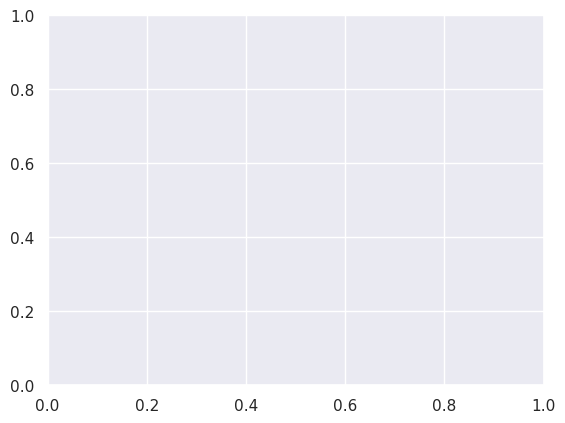

In [ ]:
plt.scatter(ks, ks_torus)
plt.title("Diffusion Curvature vs Real Curvature of Torus")
plt.xlabel("Gaussian Curvature")
plt.ylabel("Diffusion Curvature")

In [ ]:
X_sphere, ks_sphere = sphere(1000,use_guide_points=True)
G_sphere = get_adaptive_graph(X_sphere)
DC = DiffusionCurvature(
    laziness_method="Entropic",
    flattening_method="Fixed",
    comparison_method="Subtraction",
    graph_former = get_adaptive_graph,
)
sphere_entropy = DC.unsigned_curvature(G_sphere, t=25)[0]
print("Sphere entropies are ", sphere_entropy)
DC.curvature(G_sphere,t=25,dim=2)

Sphere entropies are  6.655565


Array([0.11335707, 0.06487274, 0.05884409, 0.05740404, 0.0642314 ,
       0.06366301, 0.05483818, 0.06147385, 0.08759928, 0.05728197,
       0.06411648, 0.08686781, 0.05503988, 0.09050846, 0.08116913,
       0.03181219, 0.12897491, 0.08714104, 0.06678724, 0.05969143,
       0.07953739, 0.07100677, 0.06172848, 0.08681393, 0.07116699,
       0.09487152, 0.08594608, 0.06987953, 0.08752728, 0.08381319,
       0.10403967, 0.09759521, 0.08669853, 0.07118797, 0.05764246,
       0.09759665, 0.10303497, 0.0868988 , 0.10510015, 0.06851149,
       0.09032917, 0.07850552, 0.04110861, 0.05405045, 0.05058098,
       0.06604719, 0.10579872, 0.0817647 , 0.07427454, 0.06593466,
       0.08328724, 0.07362413, 0.09141922, 0.10187674, 0.05985785,
       0.09553814, 0.06983089, 0.04920149, 0.07766151, 0.09164715,
       0.07969284, 0.04097891, 0.0702467 , 0.06564188, 0.08948517,
       0.0845356 , 0.09049368, 0.10028028, 0.0979805 , 0.0927496 ,
       0.08528709, 0.08123779, 0.08337545, 0.06309032, 0.08763

In [ ]:
X_plane = plane(len(X_sphere))
G_plane = get_adaptive_graph(X_plane)
plane_entropy = DC.unsigned_curvature(G_plane, t=25)[0]
print("Plane entropy is ", plane_entropy)

Plane entropy is  6.802491


## On the Plane

In [ ]:
X_plane = plane(1000)
G_plane = get_adaptive_graph(X_plane) #get_alpha_decay_graph(X_plane, decay=None, knn=15, anisotropy=1, )
P = diffusion_matrix_from_affinities(G_plane.W) #diff_op(G_plane).todense() # is sparse, by default
P = jnp.array(P)
Pt = jax_power_matrix(P,8)

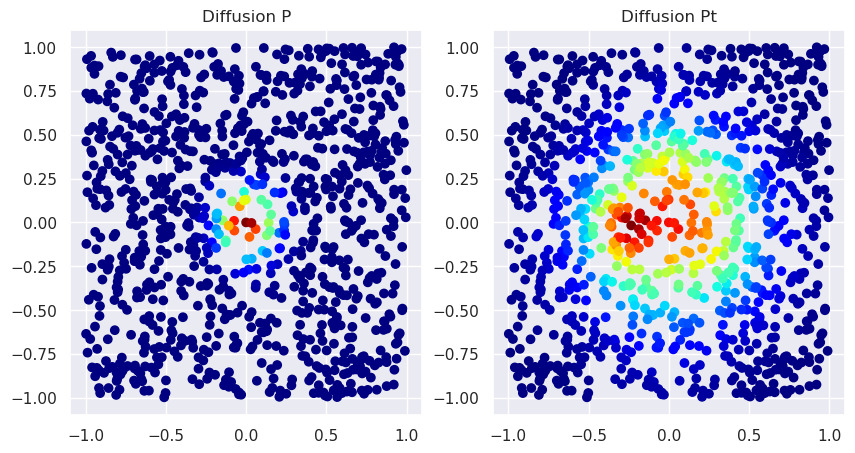

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# plot the first scatter plot
axs[0].scatter(X_plane[:,0],X_plane[:,1],c=P[0].tolist(), cmap='jet')
axs[0].set_title('Diffusion P')

# plot the second scatter plot
axs[1].scatter(X_plane[:,0],X_plane[:,1],c=Pt[0].tolist(), cmap='jet')
axs[1].set_title('Diffusion Pt')

plt.show()


In [ ]:
DC = DiffusionCurvature(laziness_method="Entropic",points_per_cluster=None,comparison_space_size_factor=1,comparison_method="Subtraction", flattening_method="Fixed")
ks_plane= DC.curvature(G_plane, t=8, dim=2, knn=15)

Let's check that higher dimensional planes are also given flat curvature

In [ ]:
ds = [3,4,5,6]
planes = [plane(1000*2**(d-2), d) for d in ds]
for i, d in enumerate(ds):
    G = get_adaptive_graph(planes[i]) #get_alpha_decay_graph(planes[i], decay=None, knn=15, anisotropy=1, )
    DC = DiffusionCurvature(laziness_method="Entropic",points_per_cluster=500,comparison_space_size_factor=1,comparison_method="Subtraction", flattening_method="Fixed")
    ks = DC.curvature(G, t=8, dim=d, knn=15)
    print("dimension",d,": Curvature of Plane is ",ks[0])

dimension 3 : Curvature of Plane is  0.0050811768
dimension 4 : Curvature of Plane is  -0.0046873093
dimension 5 : Curvature of Plane is  -0.000705719


2024-01-03 19:46:52.845911: W external/tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 976.68MiB (rounded to 1024128256)requested by op 
2024-01-03 19:46:52.846067: W external/tsl/tsl/framework/bfc_allocator.cc:497] ************************************************xx_____*************______________________________**
2024-01-03 19:46:52.846137: E external/xla/xla/pjrt/pjrt_stream_executor_client.cc:2716] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 1024128004 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:    1.91GiB
              constant allocation:         0B
        maybe_live_out allocation:  976.68MiB
     preallocated temp allocation:         0B
                 total allocation:    2.86GiB
              total fragmentation:         0B (0.00%)
Peak buffers:
	Buffer 1:
		Size: 976.68MiB
		Entry Parameter Subshape: f32[16001,16001]

	Buffe

XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 1024128004 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:    1.91GiB
              constant allocation:         0B
        maybe_live_out allocation:  976.68MiB
     preallocated temp allocation:         0B
                 total allocation:    2.86GiB
              total fragmentation:         0B (0.00%)
Peak buffers:
	Buffer 1:
		Size: 976.68MiB
		Entry Parameter Subshape: f32[16001,16001]
		==========================

	Buffer 2:
		Size: 976.68MiB
		Entry Parameter Subshape: f32[16001,16001]
		==========================

	Buffer 3:
		Size: 976.68MiB
		Operator: op_name="jit(fn)/jit(main)/add" source_file="/home/piriac/Pumberton/Workshop/21-SUMRY-Curvature/diffusion_curvature/diffusion_curvature/graphs.py" source_line=131
		XLA Label: fusion
		Shape: f32[16001,16001]
		==========================



In [ ]:
ds = [3,4,5,6]
planes = [plane(1000*2**(d-2), d) for d in ds]
for i, d in enumerate(ds):
    G = get_adaptive_graph(planes[i]) #get_alpha_decay_graph(planes[i], decay=None, knn=15, anisotropy=1, )
    DC = DiffusionCurvature(laziness_method="Entropic",points_per_cluster=None,comparison_space_size_factor=1,comparison_method="Subtraction", flattening_method="Fixed")
    ks = DC.curvature(G, t=8, dim=d, knn=15)
    print("dimension",d,": Curvature of Plane is ",ks[0])

## How bout a donut?

### With Fixed Flattening

In [ ]:
X_torus,ks = torus(5000,use_guide_points=False)
G_torus = get_adaptive_graph(X_torus) #graphtools.Graph(X_torus, anisotropy=1, knn=15, decay=None).to_pygsp()
P = diffusion_matrix_from_affinities(G_torus.W) # is sparse, by default
P = jnp.array(P)
Pt = jax_power_matrix(P,30)

In [ ]:
DC = DiffusionCurvature(
    laziness_method="Entropic",
    flattening_method="Fixed",
    comparison_method="Subtraction",
    points_per_cluster=None, # construct separate comparison spaces around each point
    comparison_space_size_factor=1
    )
ks_torus = DC.curvature(G_torus, t=30, dim=2, knn=15)

In [ ]:
plot_3d(X_torus,ks_torus,colorbar=True,title='Diffusion Comparison Curvature of the Torus')

In [ ]:
plt.scatter(ks, ks_torus)
plt.title("Diffusion Curvature vs Real Curvature of Torus")
plt.xlabel("Gaussian Curvature")
plt.ylabel("Diffusion Curvature")

### With Grid

In [ ]:
DC = DiffusionCurvature(
    laziness_method="Entropic",
    flattening_method="Fixed",
    comparison_method="Subtraction",
    points_per_cluster=None, # construct separate comparison spaces around each point
    comparison_space_size_factor=1,
    use_grid=True,
    )
ks_torus = DC.curvature(G_torus, t=25, dim=2, knn=15)

In [ ]:
plot_3d(X_torus,ks_torus,colorbar=True,title='Diffusion Comparison Curvature of the Torus')

In [ ]:
plt.scatter(ks, ks_torus)
plt.title("Diffusion Curvature vs Real Curvature of Torus")
plt.xlabel("Gaussian Curvature")
plt.ylabel("Diffusion Curvature")

### With Wasserstein

In [ ]:
DC = DiffusionCurvature(
    laziness_method="Wasserstein",
    flattening_method="Fixed",
    comparison_method="Ollivier",
    points_per_cluster=None, # construct separate comparison spaces around each point
    comparison_space_size_factor=1,
    )
ks_torus = DC.curvature(G_torus, t=15, dim=2, knn=15)

In [ ]:
plot_3d(X_torus,ks_torus,colorbar=True,title='Diffusion Wasserstein Curvature of the Torus')

In [ ]:
plt.scatter(ks, ks_torus)
plt.title("Diffusion Curvature vs Real Curvature of Torus")
plt.xlabel("Gaussian Curvature")
plt.ylabel("Diffusion Curvature")

In [ ]:
plot_3d(X_torus,ks_torus,colorbar=True,title='Diffusion Comparison Curvature of the Torus')

In [ ]:
plt.scatter(ks, ks_torus)
plt.title("Diffusion Curvature vs Real Curvature of Torus")
plt.xlabel("Gaussian Curvature")
plt.ylabel("Diffusion Curvature")

### With Laziness

In [ ]:
from functools import partial

In [ ]:
def graph_from_gaussian_kernel(X, sigma = 0, alpha = 0):
    W = gaussian_kernel(
        X,
        kernel_type='fixed',
        sigma = sigma, # use median heuristic
        anisotropic_density_normalization = alpha,
    )
    G = SimpleGraph(W = W)
    return G

In [ ]:
DC = DiffusionCurvature(
    laziness_method="Laziness",
    flattening_method="Fixed",
    comparison_method="Subtraction",
    points_per_cluster=None, # construct separate comparison spaces around each point
    comparison_space_size_factor=1,
    aperture=30,
    smoothing = 1,
    graph_former = partial(graph_from_gaussian_kernel, sigma=0.05),
    
)
ks_torus = DC.curvature(G_torus, t=30, dim=2)

In [ ]:
uks = DC.unsigned_curvature(G_torus,t=30)

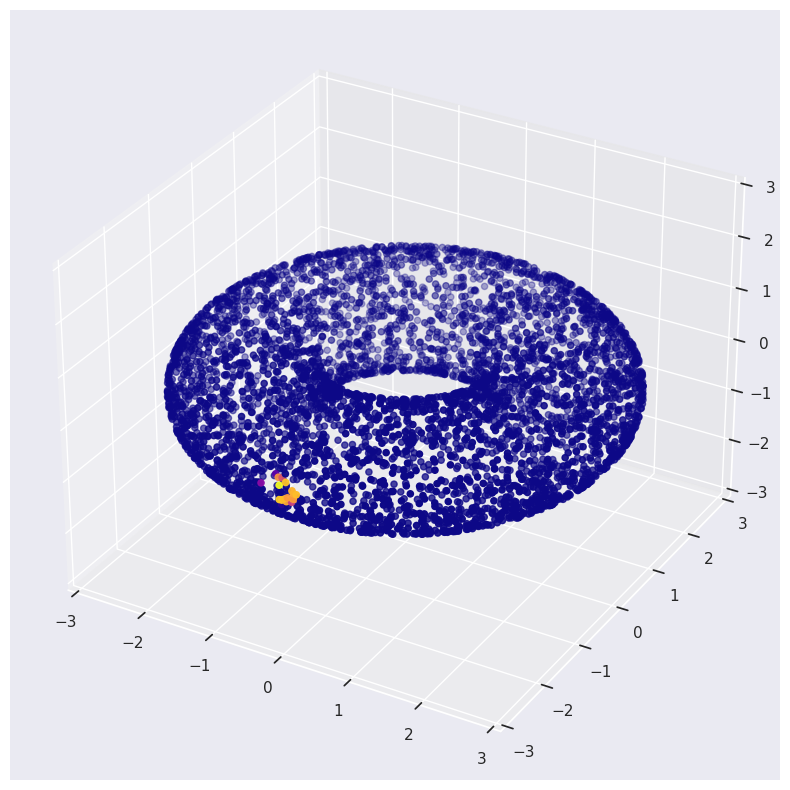

In [ ]:
plot_3d(X_torus,DC.P[0])

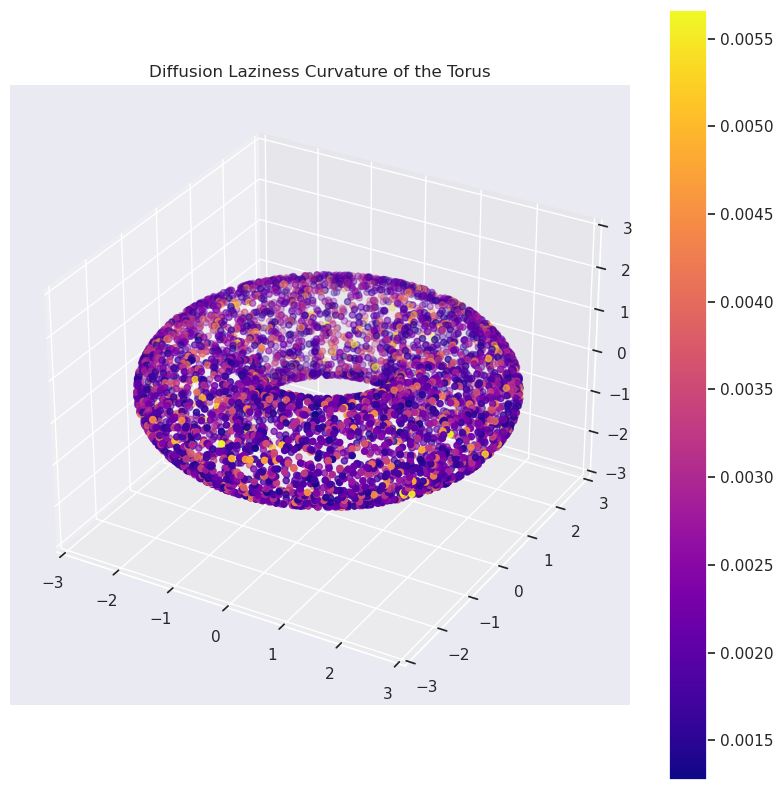

In [ ]:
plot_3d(X_torus,ks_torus,colorbar=True,title='Diffusion Laziness Curvature of the Torus')

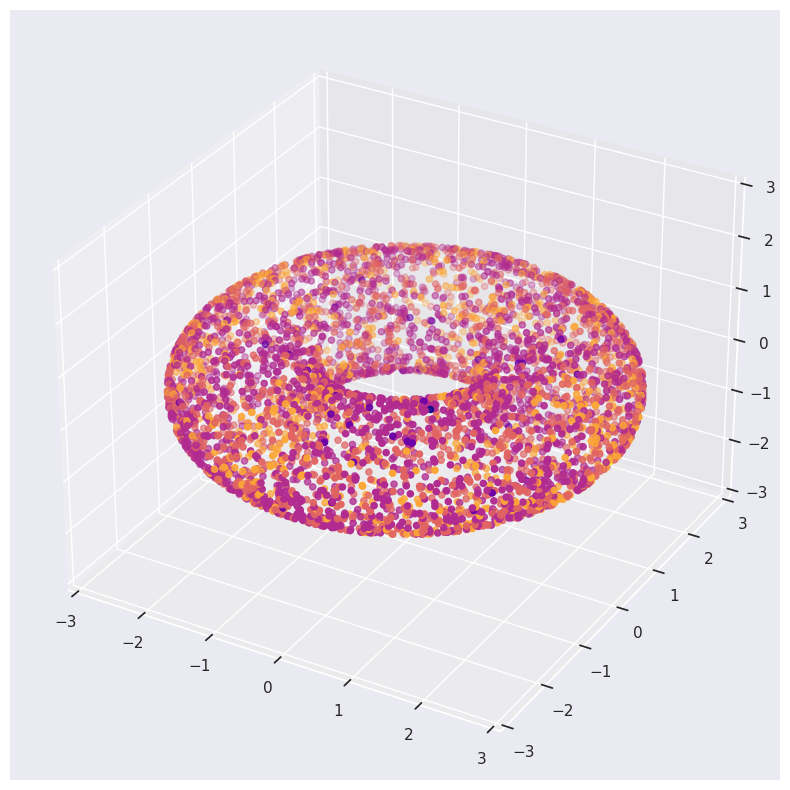

In [ ]:
plot_3d(X_torus,uks)

In [ ]:
plt.scatter(ks, ks_torus)
plt.title("Diffusion Curvature vs Real Curvature of Torus")
plt.xlabel("Gaussian Curvature")
plt.ylabel("Diffusion Curvature")

### With VNE t selection

In [ ]:
DC = DiffusionCurvature(
    laziness_method="Entropic",
    flattening_method="Fixed",
    comparison_method="Subtraction",
    points_per_cluster=None, # construct separate comparison spaces around each point
    comparison_space_size_factor=1,
    use_grid=True,
    )
ks_torus = DC.curvature(G_torus, t=None, dim=2, knn=15)

<class 'scipy.sparse._csr.csr_matrix'>


2024-01-03 20:44:48,884:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


(1000,)
<class 'scipy.sparse._csr.csr_matrix'>


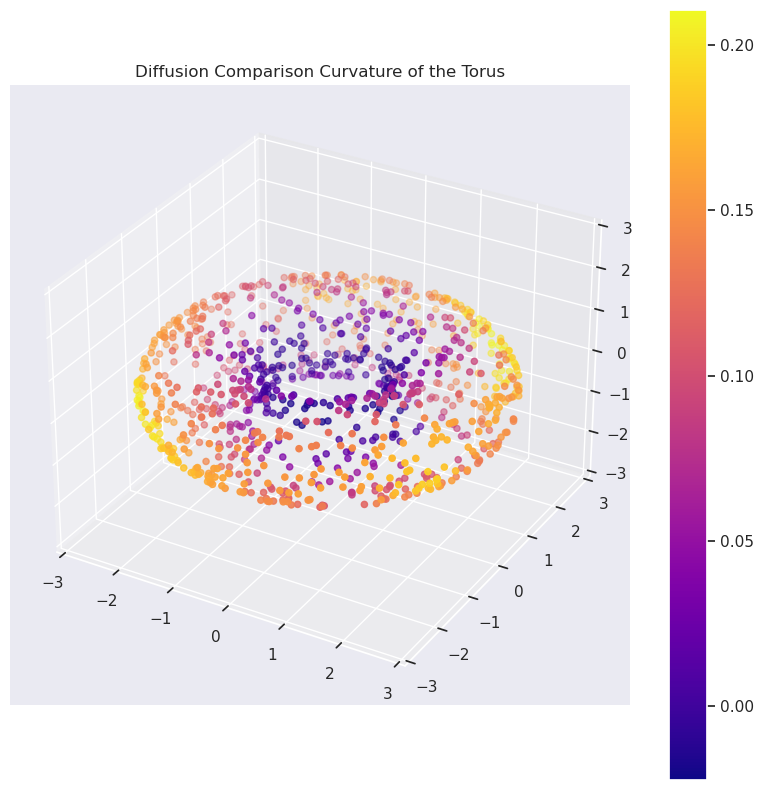

In [ ]:
plot_3d(X_torus,ks_torus,colorbar=True,title='Diffusion Comparison Curvature of the Torus')

In [ ]:
plt.scatter(ks, ks_torus)
plt.title("Diffusion Curvature vs Real Curvature of Torus")
plt.xlabel("Gaussian Curvature")
plt.ylabel("Diffusion Curvature")

### With Neural Flattening

In [ ]:
DC = DiffusionCurvature(
    laziness_method="Entropic",
    flattening_method="Neural",
    comparison_method="Subtraction",
    points_per_cluster=100, # construct separate comparison spaces around each point
    comparison_space_size_factor=10,
    max_flattening_epochs=100,
    use_grid=False,
    )
ks_torus = DC.curvature(G_torus, t=25, dim=2, knn=15)

In [ ]:
plot_3d(X_torus,ks_torus,colorbar=True,title='Diffusion Comparison Curvature of the Torus')

In [ ]:
plt.scatter(ks, ks_torus)
plt.title("Diffusion Curvature vs Real Curvature of Torus")
plt.xlabel("Gaussian Curvature")
plt.ylabel("Diffusion Curvature")

In [ ]:
DC = DiffusionCurvature(
    laziness_method="Entropic",
    flattening_method="Fixed",
    comparison_method="Subtraction",
    points_per_cluster=None, # construct separate comparison spaces around each point
    comparison_space_size_factor=1
    )
ks_torus_at_idx = DC.curvature(G_torus, t=15, dim=2, knn=15, idx=12)

In [ ]:
ks_torus_at_idx

In [ ]:
uks = DC.unsigned_curvature(G_torus,t=15)

In [ ]:
uks

In [ ]:
plot_3d(X_torus,uks,colorbar=True)

In [ ]:
labels = enhanced_spectral_clustering(G_torus, uks, dim=2, num_clusters=9, )

In [ ]:
plot_3d(X_torus,labels)

In [ ]:
entropy_of_diffusion(Pt[0])

In [ ]:
fakePt = jnp.concatenate([Pt[0], jnp.zeros(len(Pt[0]))])
entropy_of_diffusion(jnp.concatenate([Pt[0], jnp.zeros(len(Pt[0]))]))

In [ ]:
jax.scipy.special.entr(jnp.concatenate([Pt[0], jnp.zeros(len(Pt[0]))]))

In [ ]:
# get num nonzero entries in fakePt
jnp.sum(fakePt>1e-10)

In [ ]:
(-jnp.log(1/jnp.sum(fakePt>1e-10, axis=-1)))

In [ ]:
jnp.sum(jax.scipy.special.entr(jnp.ones(10)/10))

### With Mean Flattening

In [ ]:
DC = DiffusionCurvature(
    laziness_method="Entropic",
    flattening_method="Mean Fixed",
    comparison_method="Subtraction",
    points_per_cluster=None, # construct separate comparison spaces around each point
    comparison_space_size_factor=1,
    use_grid=False,
    )
ks_torus = DC.curvature(G_torus, t=25, dim=2, knn=15)

In [ ]:
plot_3d(X_torus,ks_torus,colorbar=True,title='Diffusion Comparison Curvature of the Torus')

In [ ]:
plt.scatter(ks, ks_torus)
plt.title("Diffusion Curvature vs Real Curvature of Torus")
plt.xlabel("Gaussian Curvature")
plt.ylabel("Diffusion Curvature")

In [ ]:
!nbdev_export